In [19]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


# Dataset paths
train_dir = './PlantVillage/train'
val_dir = './PlantVillage/val'

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

num_classes = len(train_dataset.classes)


In [20]:
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

In [21]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc
for param in model.layer4.parameters():
    param.requires_grad = True

# Define custom classifier head
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.BatchNorm1d(256),        # improves convergence
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)

# Ensure new head is trainable
for param in model.fc.parameters():
    param.requires_grad = True

# Apply Kaiming initialization to new Linear layers
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

model.fc.apply(init_weights)

model = model.to(device)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-5
)

In [25]:
import matplotlib.pyplot as plt

num_epochs = 10
train_accuracies = []
val_accuracies = []
train_losses = []

best_val_acc = 0.0
best_model_path = "best_resnet50.pth"

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    # --- Save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved Best Model at Epoch {epoch+1} with Val Acc: {val_acc:.2f}%")

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Val Acc: {val_acc:.2f}%")

# --- Print all epoch-level results after training ---
print("\n Epoch-level Summary:")
for i in range(num_epochs):
    print(f"Epoch {i+1:2d}: Train Acc = {train_accuracies[i]:.2f}%, "
          f"Val Acc = {val_accuracies[i]:.2f}%, "
          f"Loss = {train_losses[i]:.4f}")


Saved Best Model at Epoch 1 with Val Acc: 97.75%
Epoch [1/10] - Train Loss: 0.2238, Train Acc: 93.78%, Val Acc: 97.75%
Saved Best Model at Epoch 2 with Val Acc: 98.32%
Epoch [2/10] - Train Loss: 0.0995, Train Acc: 96.95%, Val Acc: 98.32%
Saved Best Model at Epoch 3 with Val Acc: 98.38%
Epoch [3/10] - Train Loss: 0.0747, Train Acc: 97.88%, Val Acc: 98.38%
Saved Best Model at Epoch 4 with Val Acc: 98.80%
Epoch [4/10] - Train Loss: 0.0580, Train Acc: 98.27%, Val Acc: 98.80%
Saved Best Model at Epoch 5 with Val Acc: 98.93%
Epoch [5/10] - Train Loss: 0.0520, Train Acc: 98.46%, Val Acc: 98.93%
Epoch [6/10] - Train Loss: 0.0432, Train Acc: 98.72%, Val Acc: 98.79%
Epoch [7/10] - Train Loss: 0.0377, Train Acc: 98.88%, Val Acc: 98.91%
Saved Best Model at Epoch 8 with Val Acc: 99.14%
Epoch [8/10] - Train Loss: 0.0341, Train Acc: 98.99%, Val Acc: 99.14%
Epoch [9/10] - Train Loss: 0.0300, Train Acc: 99.10%, Val Acc: 98.96%
Saved Best Model at Epoch 10 with Val Acc: 99.21%
Epoch [10/10] - Train Loss

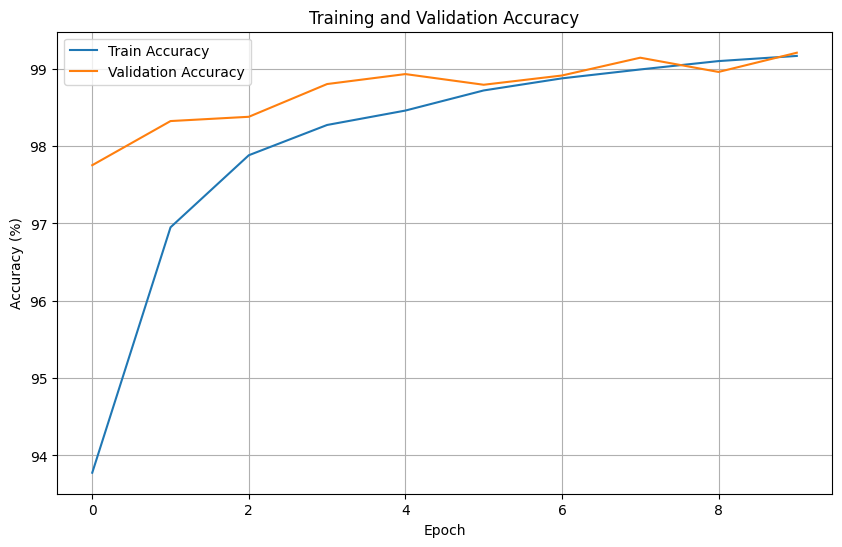

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()